##### Study initial dataset

In [1]:
import os
from pathlib import Path
from pymatgen.io.cif import CifWriter
from mp_api.client import MPRester
import pandas as pd
import json
import ormsgpack as mp
import numpy as np
from matplotlib_venn import venn2
api_key='os.environ.get('MP_API_KEY')'
ids = pd.read_csv("./data/material-data/mp-ids-46744.csv")
ids = [list(ids)[0]]+list(ids.iloc[:, 0])
print(len(ids))

46744


In [37]:
# my venn diagram for two sets
def venn(**kvarg):
    subsets = []
    set_labels = []
    for k,v in kvarg.items():
        subsets.append(set(v))
        set_labels.append(k)
    return venn2(subsets=subsets,set_labels=set_labels)
# get duplicates set of duplicates
def get_duplicates_list(a:list): 
    h = dict()
    for x in a:
        h.setdefault(x,0)
        h[x]+=1
    repeated = list()
    for k,v in h.items():
        if v>1:
            repeated+=[k for i in range(1,v)]
    return repeated

def get_duplicates_set(a:list):
    return set(get_duplicates_list(a))

In [ ]:
# naive
with MPRester(api_key) as mpr:
    naive_docs = mpr.materials.search(material_ids=ids, fields=['material_id'])
    depr_naive_docs = mpr.materials.search(material_ids=ids, fields=['material_id'], deprecated=True)

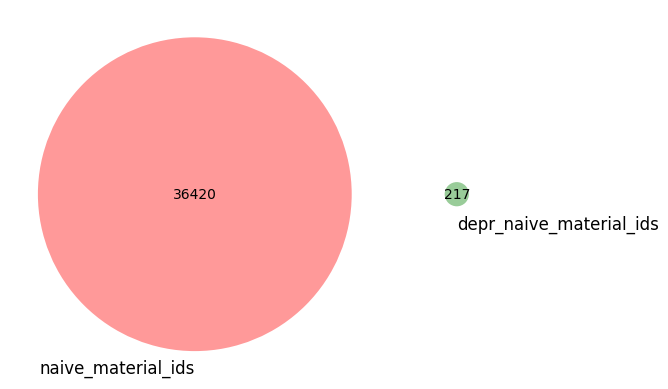

In [59]:
naive_material_ids = [str(d.material_id) for d in naive_docs]
naive_material_ids_repeated = get_duplicates_set(naive_material_ids)

depr_naive_material_ids = [str(d.material_id) for d in depr_naive_docs]
depr_naive_material_ids_repeated = get_duplicates_set(depr_naive_material_ids)
venn(naive_material_ids=naive_material_ids,
     depr_naive_material_ids=depr_naive_material_ids)

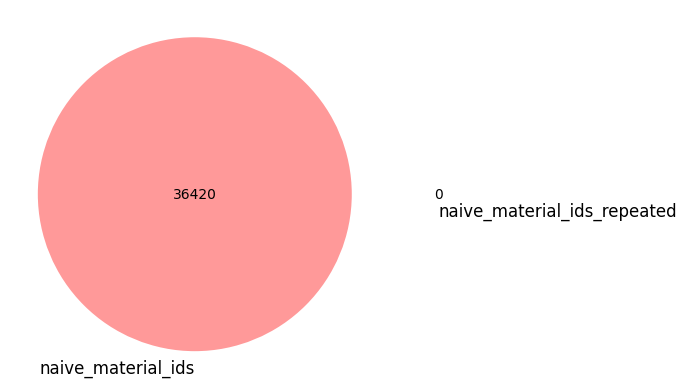

In [60]:
venn(naive_material_ids=naive_material_ids,
     naive_material_ids_repeated=naive_material_ids_repeated)

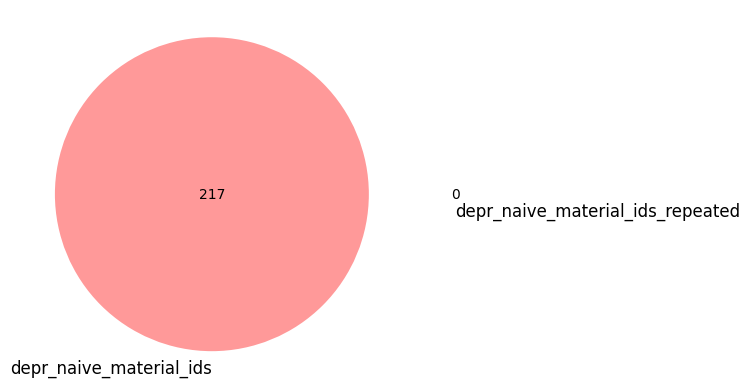

In [61]:
venn(depr_naive_material_ids=depr_naive_material_ids,
     depr_naive_material_ids_repeated=depr_naive_material_ids_repeated)

In [22]:
# non-naive approach
with MPRester(api_key) as mpr:
    docs = mpr.materials.search(task_ids=ids, fields=['material_id'])
    depr_docs = mpr.materials.search(task_ids=ids, fields=['material_id'],deprecated=True)

/home/nodoteve/apps/pythom/miniconda/envs/cgcnn2/lib/python3.11/site-packages/mp_api/client/mprester.py:227: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving MaterialsDoc documents:   0%|          | 0/46405 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1120 [00:00<?, ?it/s]

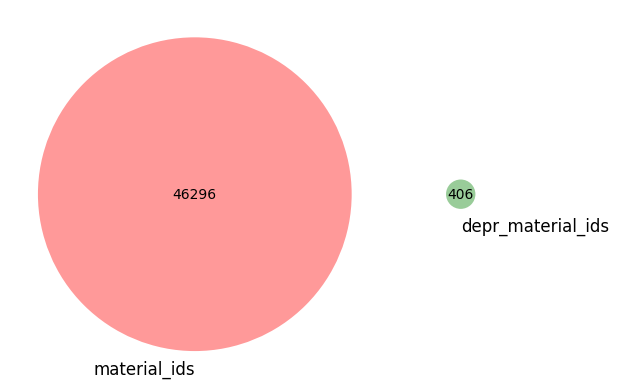

In [56]:
material_ids = [str(d.material_id) for d in docs]
material_ids_repeated = get_duplicates_set(material_ids)

depr_material_ids = [str(d.material_id) for d in depr_docs]
depr_material_ids_repeated = get_duplicates_set(depr_material_ids)

venn(material_ids=material_ids,
     depr_material_ids=depr_material_ids)

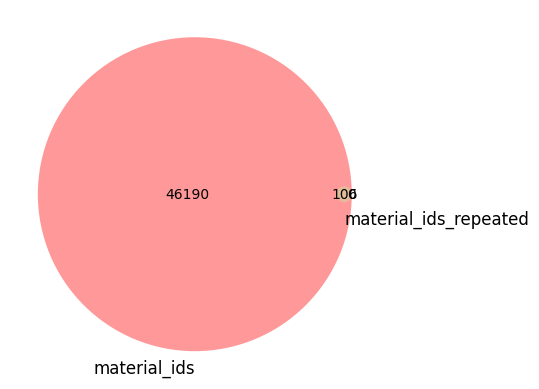

In [57]:
venn(material_ids=material_ids,
     material_ids_repeated=material_ids_repeated)

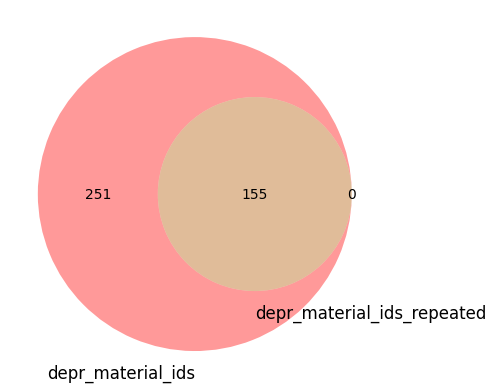

In [58]:
venn(depr_material_ids=depr_material_ids,
     depr_material_ids_repeated=depr_material_ids_repeated)

In [21]:
all_mids = list(set(material_ids).union(set(depr_material_ids)))
mids = list(set(material_ids))
depr_mids = list(set(depr_material_ids))
with MPRester(api_key) as mpr:
    docs2 = mpr.materials.search(material_ids=mids, fields=["material_id", "task_ids"])
    depr_docs2 = mpr.materials.search(material_ids=depr_mids, fields=["material_id", "task_ids"], deprecated=True)
    # equivalent
    all_docs2 = mpr.materials.search(material_ids=all_mids, fields=["material_id", "task_ids"])
    depr_all_docs2 = mpr.materials.search(material_ids=all_mids, fields=["material_id", "task_ids"], deprecated=True)

Retrieving MaterialsDoc documents:   0%|          | 0/46296 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/413 [00:00<?, ?it/s]

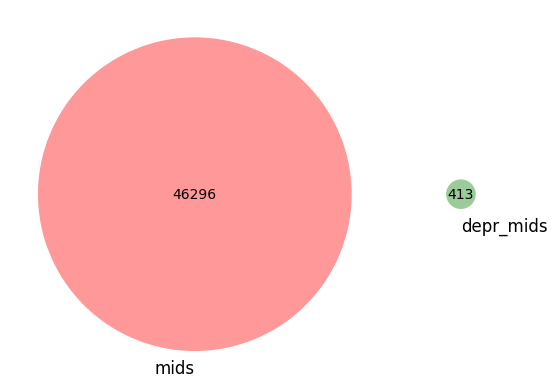

In [67]:
mids = [str(d.material_id) for d in all_docs2]
depr_mids = [str(d.material_id) for d in depr_all_docs2]
venn(mids=mids,depr_mids=depr_mids)
# => mids are unique

In [66]:
mtids = [(str(d.material_id),[str(x) for x in d.task_ids]) for d in all_docs2]
depr_mtids = [(str(d.material_id),[str(x) for x in d.task_ids]) for d in depr_all_docs2]
# keep only task_ids from (initial) ids.
sids = set(ids)
redused_mtids = [(m,[x for x in t if x in sids]) for m,t in mtids]
redused_depr_mtids = [(m,[x for x in t if x in sids]) for m,t in depr_mtids]

# flatten
all_tids = []
for m,t in redused_mtids:
    all_tids += t
for m,t in redused_depr_mtids:
    all_tids += t
print(len(get_duplicates_set(all_tids)))
# => correspondence between tids and mids not strictly obeys the law that there is only one mid for the given tid. (but it should)
# Explanation: duplicates appears after addition of deprecated part => deprecation is a task_id property,
# but not the resulting material_id property. Therefore, some undeprecated mids can be accessed by deprecated tids.

796
10072


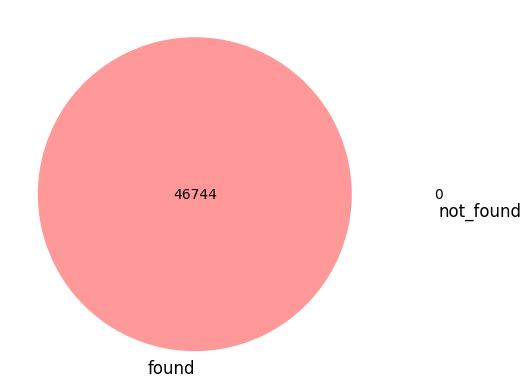

In [68]:
# compare with (initial) ids

# create map ids -> material_ids
t2m = dict()
for m,t in mtids:
    for x in t:
        t2m[x]=m
for m,t in depr_mtids:
    for x in t:
        t2m[x]=m
found=[x for x in ids if x in t2m]
not_found=[x for x in ids if x not in t2m]
venn(found=found,not_found=not_found)

In [69]:
# set theoretical image of ids after t2m
img = [t2m[x] for x in ids]

45914 830 265


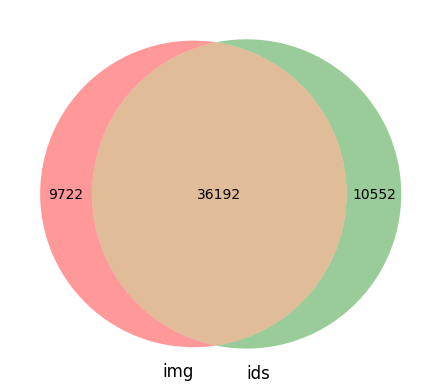

In [70]:
print(len(set(img)),len(get_duplicates_list(img)),len(get_duplicates_set(img)))
venn(img=img, ids=ids)
# => Actual number of duplicates (data leak) in article implementation is about 830 ids (~1.8%)

#### Reimplement dataset with data leak, and then without.


In [73]:
# def save_structure_to_cif(structure, output_file):
#     with open(output_file, "w") as f:
#         cif_writer = CifWriter(structure)
#         cif_writer.write_file(f.name)


# def save_properties_to_json(properties: dict, output_file):
#     with open(output_file, "w") as f:
#         json.dump(properties, f)


cifs_file = "./data/root/data/cifs.bin"
def save_structures_to_bin(structures: dict, output_file=cifs_file):
    with open(output_file, "wb") as f:
        f.write(mp.packb(structures, option=mp.OPT_NON_STR_KEYS))


props_file = "./data/root/data/props.bin"
def save_properties_to_bin(properties: dict, output_file=props_file):
    with open(output_file, "wb") as f:
        f.write(mp.packb(properties, option=mp.OPT_NON_STR_KEYS))


# fields=['formation_energy_per_atom']
fields = [
    "energy_per_atom",
    "formation_energy_per_atom",
    "band_gap",
    "efermi",
    "k_voigt",
    "k_reuss",
    "k_vrh",
    "g_voigt",
    "g_reuss",
    "g_vrh",
    "homogeneous_poisson",
]
depr_docs=[]
docs=[]
def download_all():
    global docs,depr_docs
    with MPRester(api_key) as mpr:
        # docs = mpr.materials.summary.search(
        #     material_ids=img, fields=fields + ["structure", "material_id"]
        # )
        # depr_docs = mpr.materials.summary.search(material_ids=img,
        #                                      fields=fields + ["structure", "material_id"],
        #                                      deprecated=True)
    all_docs = depr_docs+docs
    props = dict()
    cifs = dict()
    for d in all_docs:
        # output_file = f"./data/root/{d.material_id}.cif"
        # save_structure_to_cif(d.structure, output_file)
        # save_properties_to_json(d.model_dump(include=fields),f"props/{d.material_id}.json")
        cifs[d.material_id] = d.structure.as_dict()
        props[d.material_id] = d.model_dump(include=fields)
    save_structures_to_bin(cifs)
    save_properties_to_bin(props)
    # uncorrected_energy_per_atom energy_per_atom formation_energy_per_atom band_gap efermi
    #  see https://docs.materialsproject.org/methodology/materials-methodology/elasticity/ k <-> bulk, g <-> shear
    # k_vrh g_vrh homogeneous_poisson
download_all()

/home/nodoteve/apps/pythom/miniconda/envs/cgcnn2/lib/python3.11/site-packages/mp_api/client/mprester.py:227: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/45609 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1119 [00:00<?, ?it/s]

In [74]:
# compress with zstd
import zstandard as zstd


def compress_all():
    with open(cifs_file, "rb") as f:
        res = zstd.compress(f.read(), level=10)
    with open("./data/root/cifs.zstd", "wb") as f:
        f.write(res)
    with open(props_file, "rb") as f:
        res = zstd.compress(f.read(), level=10)
    with open("./data/root/props.zstd", "wb") as f:
        f.write(res)


compress_all()



def uncompress_all():
    with open("./data/root/cifs.zstd", "rb") as f:
        res = zstd.decompress(f.read())
    with open(cifs_file, "wb") as f:
        f.write(res)
    with open("./data/root/props.zstd", "rb") as f:
        res = zstd.decompress(f.read())
    with open(props_file, "wb") as f:
        f.write(res)


uncompress_all()

In [116]:
# print data statistics for first dataset
basedir = './data/root/data/'

# propfiles = os.listdir(basedir)
def load_properties_from_json(file):
    filename = os.path.basename(file)
    with open(basedir + file, "rb") as f:
        properties = json.load(f)
        return (filename, properties)
    return None


def load_properties_from_bin(file):
    with open(file, "rb") as f:
        properties = mp.unpackb(f.read())
        return properties
    return None

# propdata = dict()
# for file in propfiles:
#     name,prop=load_properties_from_json(file)
#     for key in prop.keys():
#         propdata.setdefault(key,[])
#         propdata[key].append(prop[key])

full_df = pd.DataFrame(load_properties_from_bin(basedir + "props.bin")).transpose()
import numpy as np

for moduli in ["k_voigt", "k_reuss", "k_vrh", "g_voigt", "g_reuss", "g_vrh"]:
    full_df[moduli] = np.log(full_df[moduli])
full_df.describe()
# f.to_csv('./test_missing.csv')

/home/nodoteve/apps/pythom/miniconda/envs/cgcnn2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,energy_per_atom,formation_energy_per_atom,band_gap,efermi,k_voigt,k_reuss,k_vrh,g_voigt,g_reuss,g_vrh,homogeneous_poisson
count,45501.000000,45501.000000,45914.000000,45914.000000,5555.000000,5538.000000,5553.000000,5514.000000,5354.000000,5464.000000,5568.000000
mean,-6.413375,-1.699209,1.399455,2.921999,4.434211,4.345194,4.398808,3.725197,3.522782,3.629232,0.294442
std,1.776623,1.060145,1.665423,2.680512,0.833179,0.966218,0.870240,0.873272,1.078459,0.936328,0.362351
min,-14.076122,-4.499302,0.000000,-14.017281,0.235898,-1.673020,0.022506,-1.944802,-6.026329,-2.208196,-13.047463
25%,-7.667722,-2.506305,0.000000,1.088021,3.952991,3.871469,3.904433,3.240739,2.982157,3.105790,0.250903
50%,-6.654340,-1.845550,0.692100,2.667559,4.628538,4.591813,4.613119,3.861791,3.704704,3.770419,0.291793
75%,-5.234887,-0.722389,2.504600,4.641063,5.063615,5.048320,5.052163,4.346580,4.277532,4.309973,0.331209
max,-0.005272,4.309211,16.586400,17.758767,6.687777,6.639926,6.664137,6.055889,7.600026,6.912284,19.038342


In [96]:
# w?
# mp-756006 - example
# energy_per_atom,formation_energy_per_atom problems (unable to solve, seems to be deleted due to deprectaion)

In [100]:
# train on all properties for 1st dataset 

In [117]:
import numpy as np
from subprocess import run
import shutil as st

resdict = dict()
maedict = dict()
reference_csv = {
    "mp-ids-3402.csv": [
        "k_voigt",
        "k_reuss",
        "k_vrh",
        "g_voigt",
        "g_reuss",
        "g_vrh",
        "homogeneous_poisson",
    ],
    "mp-ids-27430.csv": ["band_gap"],
    "mp-ids-46744.csv": ["energy_per_atom", "formation_energy_per_atom", "efermi"],
}


def set_property_to_ids(df: pd.DataFrame, property: str):
    # nids = df[property].isna()
    df[property].dropna().to_csv("./data/root/data/id_prop.csv", index=True, header=False)

def prepare_csv(csv: str, df: pd.DataFrame, prop: str):
    # st.move("./data/material-data/" + csv, "./data/root/data/id_prop.csv")
    set_property_to_ids(df, prop)



def get_df_for_csv(csv:str):
    global t2m, full_df
    ids = pd.read_csv("./data/material-data/" + csv)
    ids = [list(ids)[0]]+list(ids.iloc[:, 0])
    df = pd.DataFrame()
    for t in ids:
        m = t2m[t]
        df=pd.concat([df,full_df.loc[[m]]])
    return df


In [104]:
df = get_df_for_csv('mp-ids-27430.csv')
df.describe()

,energy_per_atom,formation_energy_per_atom,band_gap,efermi,k_voigt,k_reuss,k_vrh,g_voigt,g_reuss,g_vrh,homogeneous_poisson
count,26615.000000,26615.000000,27430.000000,27430.000000,2250.000000,2238.000000,2249.000000,2249.000000,2193.000000,2231.000000,2257.000000
mean,-6.580005,-2.163590,2.344693,1.635944,4.064046,3.900467,3.999637,3.452375,3.165768,3.333660,0.283521
std,1.590995,0.849571,1.562910,2.006971,0.912312,1.084966,0.955713,0.936332,1.182809,0.987379,0.409789
min,-12.442723,-4.499302,0.000000,-14.017281,0.235898,-1.673020,0.022506,-0.612609,-6.026329,-0.630725,-1.310392
25%,-7.718933,-2.723880,1.103500,0.381750,3.412364,3.190271,3.319801,2.867155,2.492156,2.674886,0.239542
50%,-6.857425,-2.290027,2.149150,1.668234,4.174827,4.083220,4.108159,3.580489,3.332788,3.478246,0.281207
75%,-5.527791,-1.622015,3.373425,2.922877,4.845064,4.798599,4.819806,4.168842,4.037670,4.095673,0.315227
max,-0.005272,4.309211,16.586400,11.006881,5.999937,5.996381,5.998160,6.055889,6.074110,6.040247,19.038342


In [107]:
df = get_df_for_csv('mp-ids-3402.csv')
df.describe()

,energy_per_atom,formation_energy_per_atom,band_gap,efermi,k_voigt,k_reuss,k_vrh,g_voigt,g_reuss,g_vrh,homogeneous_poisson
count,3378.000000,3378.000000,3402.000000,3402.000000,3401.000000,3400.000000,3401.000000,3401.000000,3400.000000,3401.000000,3401.000000
mean,-6.215949,-0.959954,0.678802,4.812236,4.535167,4.465140,4.507788,3.863505,3.667208,3.782168,0.284104
std,2.135439,0.965489,1.353408,2.743824,0.770992,0.860045,0.794463,0.777641,0.903429,0.809492,0.060879
min,-12.958130,-4.298431,0.000000,-4.654093,1.288517,0.426736,1.269426,0.976944,-0.639653,0.886284,-0.124269
25%,-7.831029,-1.296117,0.000000,3.002715,4.086537,4.009625,4.044191,3.397700,3.143085,3.286557,0.245585
50%,-6.295464,-0.596287,0.000000,5.173001,4.710932,4.681821,4.691549,3.979850,3.835428,3.898296,0.286754
75%,-4.537358,-0.306151,0.737175,6.923026,5.113175,5.098365,5.103428,4.424533,4.331358,4.378000,0.323743
max,-0.483234,2.756673,8.695900,12.401693,6.687777,6.639926,6.664137,5.958360,5.939104,5.948779,0.467523


In [113]:
for csv in reference_csv.keys():
    df = get_df_for_csv(csv)

    for prop in reference_csv[csv]:
        prepare_csv(csv, df, prop)

        res = run(
            "conda run -n cgcnn2 python main.py --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 ./data/root/data/",
            capture_output=True,
            text=True,
            shell=True,
        )
        # result = run(['ls'], capture_output=True, text=True)
        # Write the contents of the stdout (standard output) to the file.
        resdict[prop] = res.stdout
        maedict[prop] = resdict[prop].split("** MAE ")[-1]
        print(prop, maedict[prop])

        st.move("checkpoint.pth.tar", "./trained/" + prop + "_check.pth.tar")
        st.move("model_best.pth.tar", "./trained/" + prop + "_best.pth.tar")
        st.move("test_results.csv", "./trained/" + prop + "_results.csv")
        
with open("train_outputs.json", "w") as f:
    json.dump(resdict, f)
with open("train_maes.json", "w") as f:
    json.dump(maedict, f)

k_voigt 0.144


k_reuss 0.196


k_vrh 0.163


g_voigt 0.215


g_reuss 0.304


g_vrh 0.221


homogeneous_poisson 0.032


band_gap 0.502


energy_per_atom 0.147


formation_energy_per_atom 0.077


efermi 0.482




In [118]:
def prepare_csv_no_leak(csv: str, df: pd.DataFrame, prop: str):
    df[prop].dropna().drop_duplicates().to_csv("./data/root/data/id_prop.csv", index=True, header=False)


In [119]:
for csv in reference_csv.keys():
    df = get_df_for_csv(csv)

    for prop in reference_csv[csv]:
        prepare_csv(csv, df, prop)

        res = run(
            "conda run -n cgcnn2 python main.py --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 ./data/root/data/",
            capture_output=True,
            text=True,
            shell=True,
        )
        # result = run(['ls'], capture_output=True, text=True)
        # Write the contents of the stdout (standard output) to the file.
        resdict[prop] = res.stdout
        maedict[prop] = resdict[prop].split("** MAE ")[-1]
        print(prop, maedict[prop])

        st.move("checkpoint.pth.tar", "./trained/" + prop + "_check.pth.tar")
        st.move("model_best.pth.tar", "./trained/" + prop + "_best.pth.tar")
        st.move("test_results.csv", "./trained/" + prop + "_results.csv")
        
with open("train_outputs.json", "w") as f:
    json.dump(resdict, f)
with open("train_maes.json", "w") as f:
    json.dump(maedict, f)

k_voigt 0.153


k_reuss 0.183


k_vrh 0.159


g_voigt 0.208


g_reuss 0.304


g_vrh 0.233


homogeneous_poisson 0.032


band_gap 0.524


energy_per_atom 0.120


formation_energy_per_atom 0.075


efermi 0.478


